In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
import seaborn as sns

C:\Users\omer\AppData\Local\Temp\ipykernel_15992\609083860.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from enums import stage_dict, char_dict, platform_dict, dan_names_dict, battle_type_dict
from read_data import read_data_into_dataframe
from data_processing import get_unique_players, calculate_win_rates_with_confidence_interval, get_most_popular_characters, get_rank_distribution, split_unique_players, split_replays_into_categories, calculate_percentiles
from plotting import plot_win_rates, plot_most_popular_characters, plot_rank_distribution, plot_win_rates_with_confidence_intervals

In [3]:
%matplotlib inline  

In [4]:
jsons_directory = './data/data_06_08/'
master_df = read_data_into_dataframe(jsons_directory)

Read 6345648 games from 6352 files
208 files were unable to be read


In [5]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1855631 entries, 0 to 6345647
Data columns (total 35 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   battleId       object
 1   battleType     int64 
 2   gameVersion    int64 
 3   winResult      int64 
 4   totalRoundNum  int64 
 5   battleAt       int64 
 6   viewNum        int64 
 7   stageId        object
 8   highlightFlag  bool  
 9   1pUserId       object
 10  1pPlayerName   object
 11  1pPolarisId    object
 12  1pOnlineId     object
 13  1pNgWordFlag   int64 
 14  1pPlatform     int64 
 15  1pRank         int64 
 16  1pTekkenPower  int64 
 17  1pCharaId      object
 18  1pWinRoundNum  int64 
 19  1pTagType01    int64 
 20  1pTagType02    int64 
 21  1pTagType03    int64 
 22  2pUserId       object
 23  2pPlayerName   object
 24  2pPolarisId    object
 25  2pOnlineId     object
 26  2pNgWordFlag   int64 
 27  2pPlatform     int64 
 28  2pRank         int64 
 29  2pTekkenPower  int64 
 30  2pCharaId      object
 

In [6]:
# waht percentage of games had chr_0038 in them as player 1 or player 2

# get all the games that chr_0038 was in
chr_0038_games = master_df[(master_df['1pCharaId'] == 'chr_0038') | (master_df['1pCharaId'] == 'chr_0038')]

# get the total number of games
total_games = master_df.shape[0]

# get the number of games that chr_0038 was in
chr_0038_games_count = chr_0038_games.shape[0]

# get the percentage of games that chr_0038 was in
chr_0038_games_percentage = chr_0038_games_count / total_games

print(f'chr_0038 was in {chr_0038_games_percentage * 100}% of games')


chr_0038 was in 2.486755179235527% of games


In [7]:
master_df.to_csv('output/replays.csv')
master_df.to_json('output/replays.json')

2024-06-07 to 2024-06-09


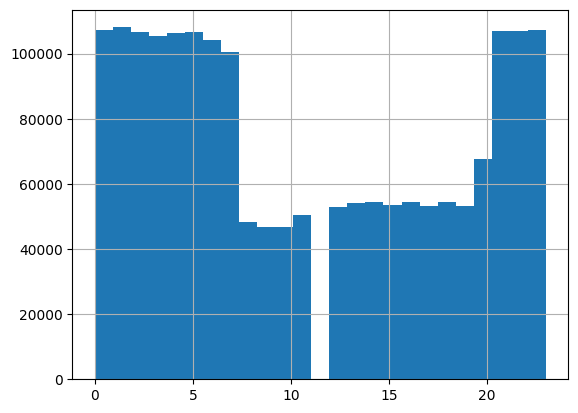

In [8]:
# convert from unix timestamp to datetime
master_df['battleAt'] = pd.to_datetime(master_df['battleAt'], unit='s')

# plot distribution of time of day game was played
master_df['battleAt'].dt.hour.hist(bins=25)

# get the date range of the data as a human readable string
data_date_range = f"{master_df['battleAt'].dt.date.min()} to {master_df['battleAt'].dt.date.max()}"
print(data_date_range)

In [9]:
unique_players = get_unique_players(master_df)
beginner_players, intemediate_players, advanced_players = split_unique_players(unique_players)
beginner_games, intermediate_games, advanced_games = split_replays_into_categories(master_df)

In [10]:
print('Number of unique players:', len(unique_players))
print('Number of beginner players:', len(beginner_players))
print('Number of intermediate players:', len(intemediate_players))
print('Number of advanced players:', len(advanced_players))
print('')
print('Number of unique games:', len(master_df))
print('Number of beginner games:', len(beginner_games))
print('Number of intermediate games:', len(intermediate_games))
print('Number of advanced games:', len(advanced_games))

print('')
print(f'{len(master_df) - (len(beginner_games) + len(intermediate_games) + len(advanced_games))} games were not categorized as they were played by players of from different categories')

Number of unique players: 158441
Number of beginner players: 35220
Number of intermediate players: 97730
Number of advanced players: 25491

Number of unique games: 1855631
Number of beginner games: 282198
Number of intermediate games: 1206668
Number of advanced games: 72025

294740 games were not categorized as they were played by players of from different categories


In [11]:
brackets_dict = {
	'beginner': {
		'players': beginner_players,
		'games': beginner_games,
		},
		'intermediate': {
			'players': intemediate_players,
			'games': intermediate_games,
		},
		'advanced': {
			'players': advanced_players,
			'games': advanced_games,
		},
} 


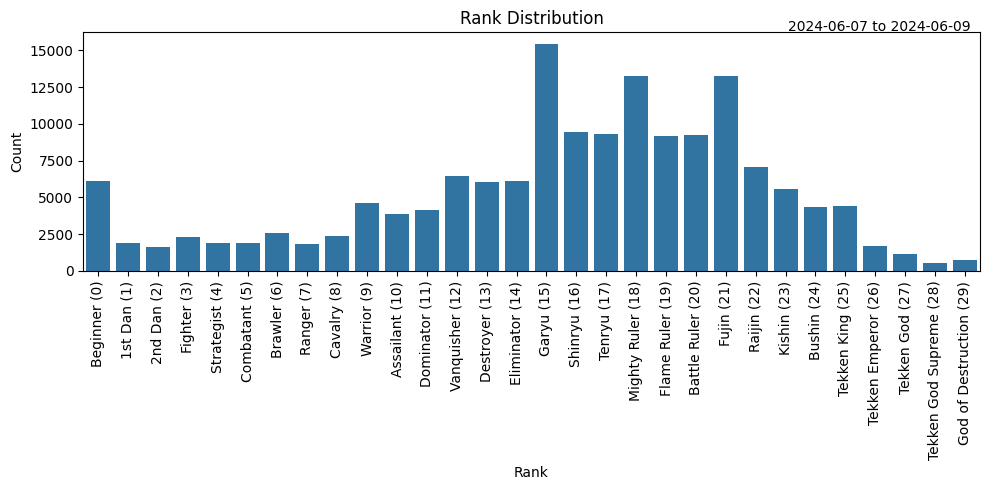

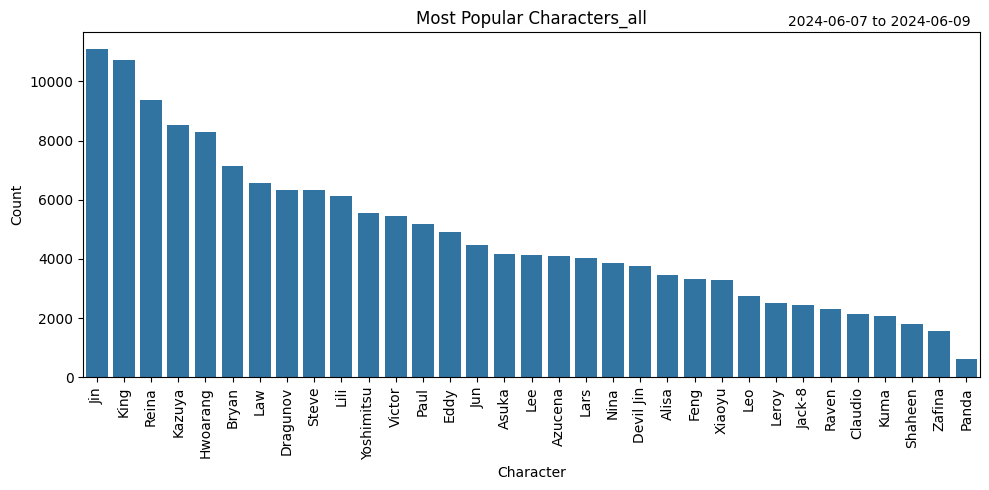

Number of mirror matches: 82037
Number of matches with draws: 0


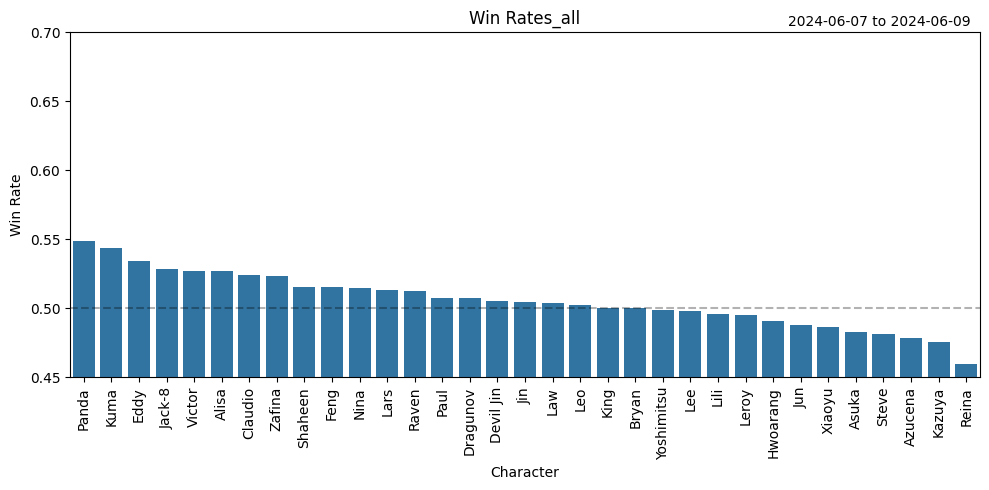

Number of mirror matches: 11800
Number of matches with draws: 0
graph_limits (0.34271609192355607, 0.6485522360591375)


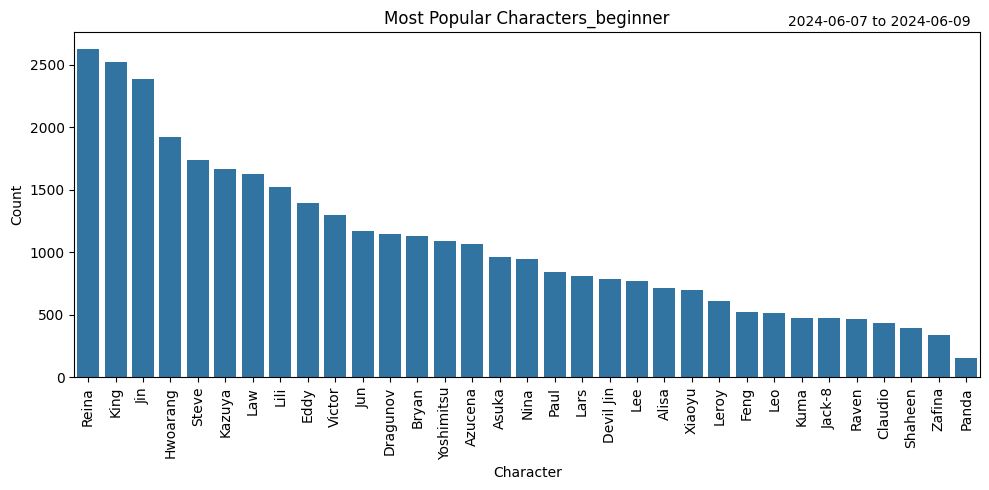

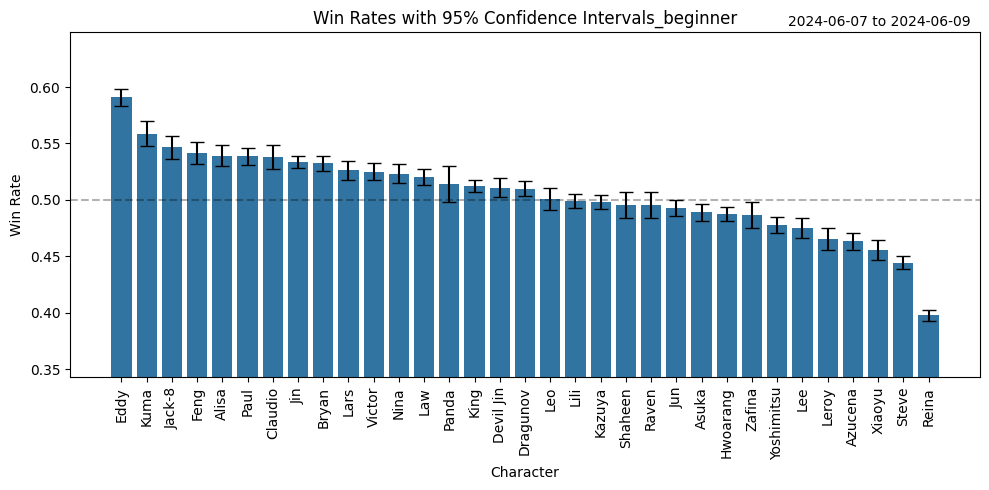

Number of mirror matches: 52013
Number of matches with draws: 0
graph_limits (0.4174705122874587, 0.6174674769727472)


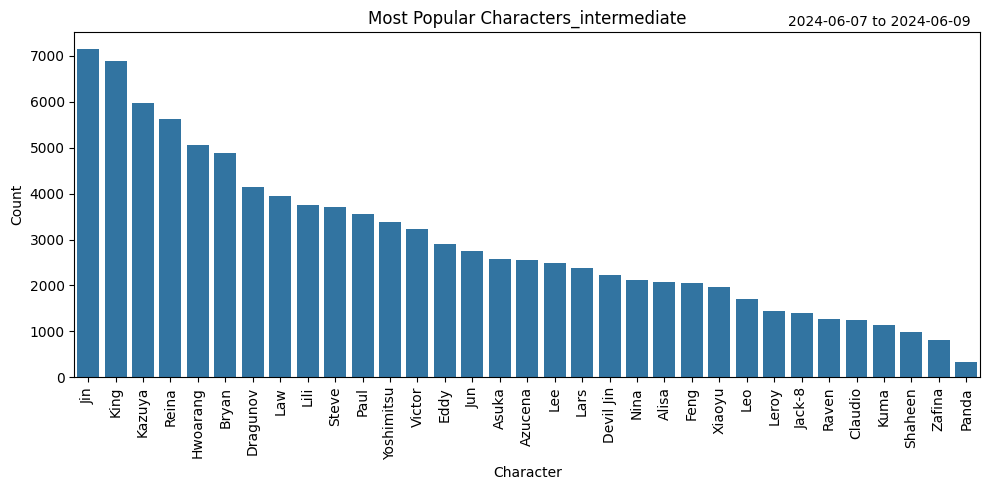

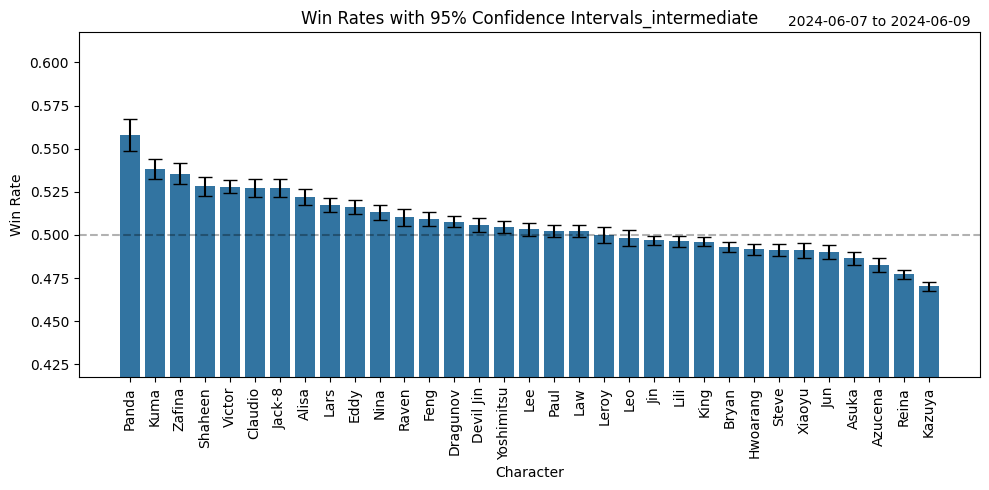

Number of mirror matches: 3063
Number of matches with draws: 0
graph_limits (0.4071709878569085, 0.6186274509803922)


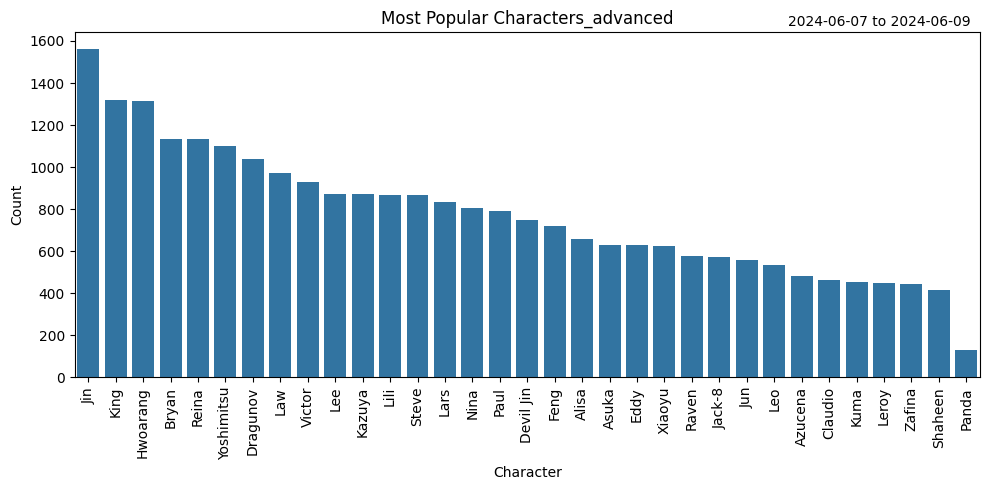

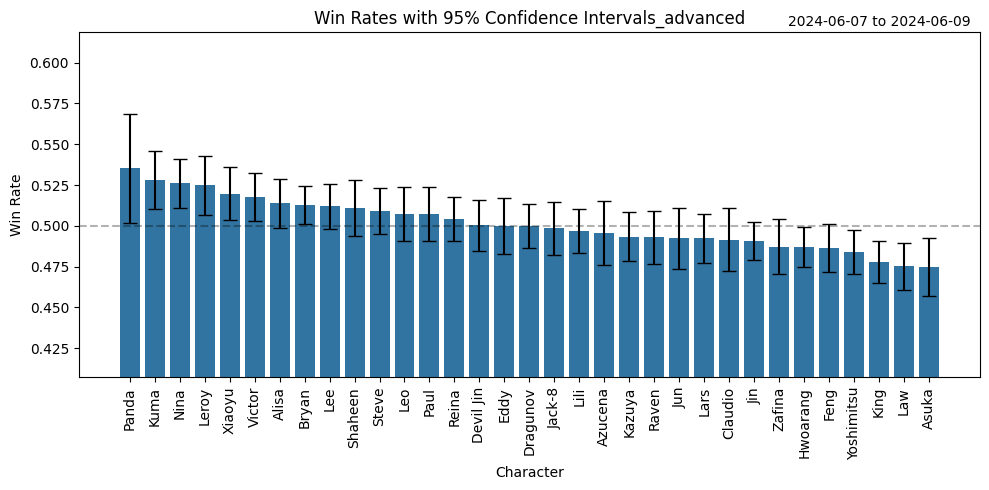

In [12]:
rank_counts = get_rank_distribution(unique_players)
plot_rank_distribution(rank_counts, date_range=data_date_range)
character_counts = get_most_popular_characters(unique_players)
plot_most_popular_characters(character_counts, 'all', date_range=data_date_range)
win_rates, intervals = calculate_win_rates_with_confidence_interval(master_df)
plot_win_rates(win_rates, 'all', date_range=data_date_range)


for bracket in brackets_dict:
    character_counts = get_most_popular_characters(brackets_dict[bracket]['players'])
    games = brackets_dict[bracket]['games']
    win_rates, intervals = calculate_win_rates_with_confidence_interval(games)
    min_winrate = np.array(list(intervals.values())).min()
    max_winrate = np.array(list(intervals.values())).max()
    graph_limits = (min(min_winrate - 0.05, 0.45) , max(max_winrate + 0.05, 0.6))
    print('graph_limits', graph_limits)
    plot_most_popular_characters(character_counts, bracket, date_range=data_date_range)
    plot_win_rates_with_confidence_intervals(win_rates, intervals, bracket_name=bracket, ylim=graph_limits, date_range=data_date_range)

In [13]:
calculate_percentiles(rank_counts)

{'Beginner': 0.0,
 '1st Dan': 3.85253816878207,
 '2nd Dan': 5.061821119533454,
 'Fighter': 6.086808338750703,
 'Strategist': 7.540977398526897,
 'Combatant': 8.760358745526727,
 'Brawler': 9.946289154953579,
 'Ranger': 11.571499801187823,
 'Cavalry': 12.736602268352257,
 'Warrior': 14.243787908432793,
 'Assailant': 17.168535921888907,
 'Dominator': 19.62244621026123,
 'Vanquisher': 22.229094741891302,
 'Destroyer': 26.296854980718376,
 'Eliminator': 30.095114269665046,
 'Garyu': 33.940709791026315,
 'Shinryu': 43.697022866556004,
 'Tenryu': 49.65318320384244,
 'Mighty Ruler': 55.52981867067236,
 'Flame Ruler': 63.8780366193094,
 'Battle Ruler': 69.68587676169679,
 'Fujin': 75.53158589001583,
 'Raijin': 83.91136132692927,
 'Kishin': 88.3679098213215,
 'Bushin': 91.86574182187691,
 'Tekken King': 94.61818594934392,
 'Tekken Emperor': 97.38767112048018,
 'Tekken God': 98.4663060697673,
 'Tekken God Supreme': 99.17887415504825,
 'God of Destruction': 99.54241641999229}

In [14]:
# quick test to make sure the average win rate is close to 50%
# it should be exactly 50% since there is a win and a loss for each game
# but that is not the case since we are not considering the play rate of each character in this simple calculation

win_rates, _ = calculate_win_rates_with_confidence_interval(master_df)

average_win_rate = sum(win_rates.values()) / len(win_rates)
if abs(average_win_rate - 0.5) < 0.05:
    print(f"The average win rate ({average_win_rate}) is close to 50%.")
else:
    print(f"The average win rate ({average_win_rate})is not close to 50%.")


Number of mirror matches: 82037
Number of matches with draws: 0
The average win rate (0.505730409357748) is close to 50%.


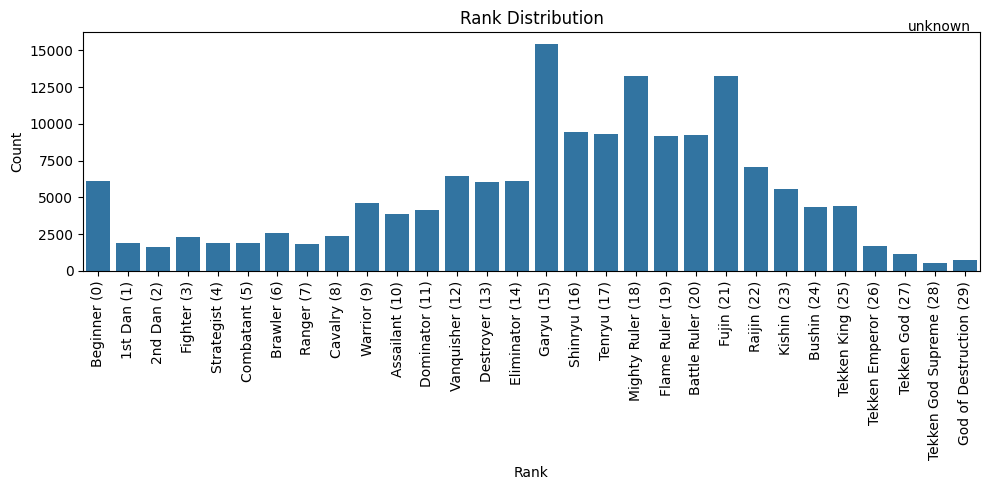

In [15]:
plot_rank_distribution(rank_counts)

chr_0000: Paul


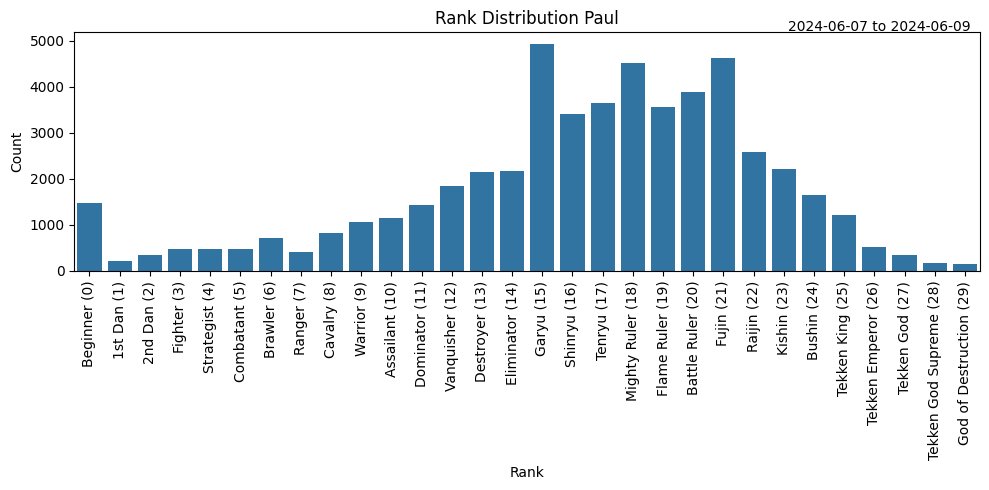

chr_0001: Law


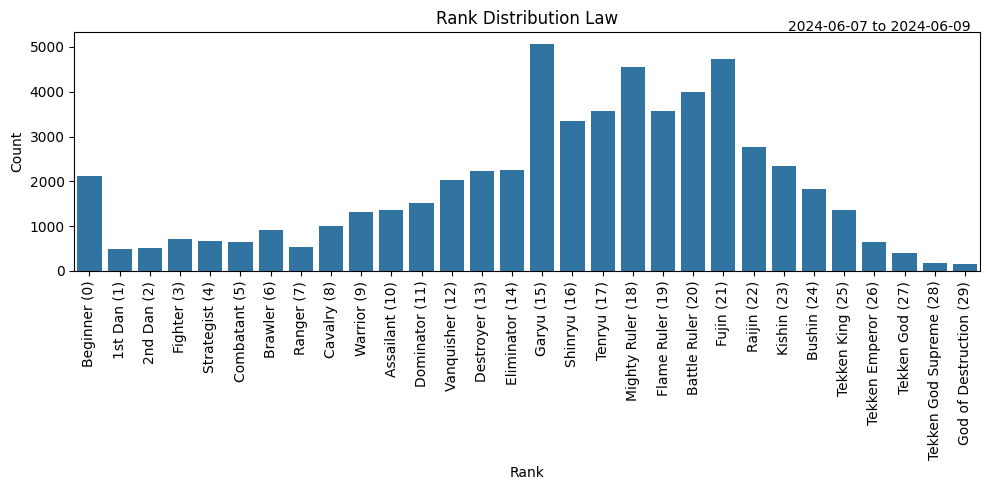

chr_0002: King


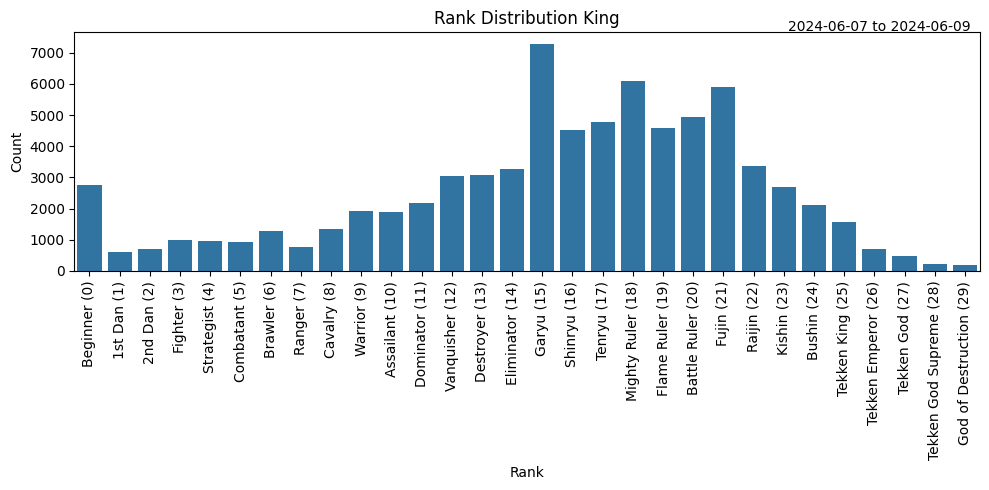

chr_0003: Yoshimitsu


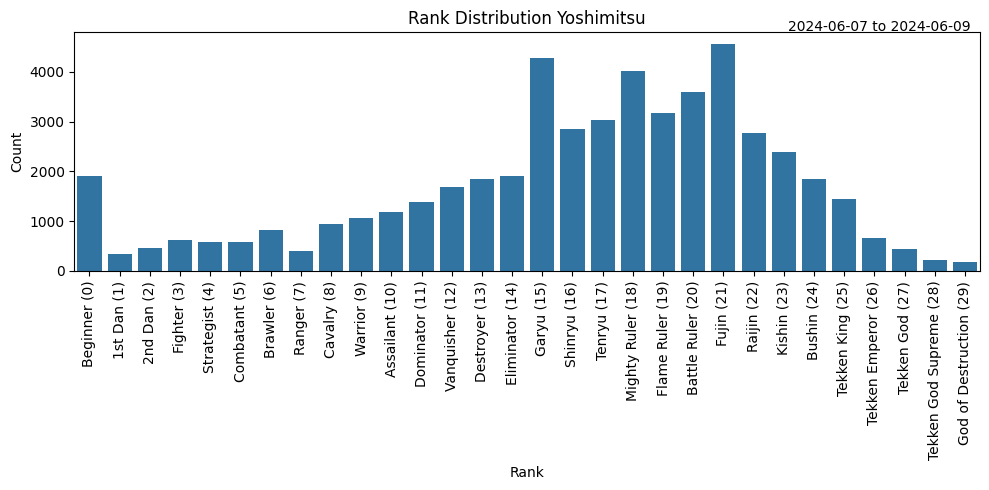

chr_0004: Hwoarang


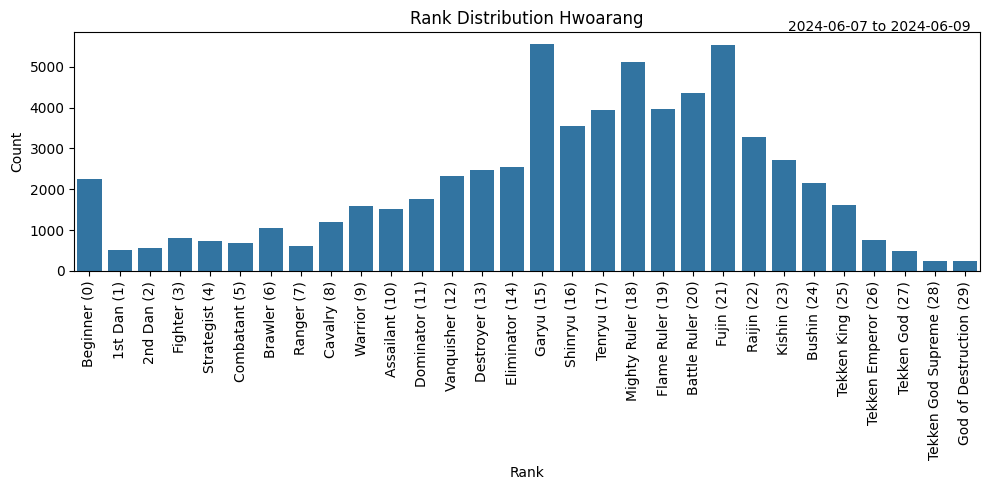

chr_0005: Xiaoyu


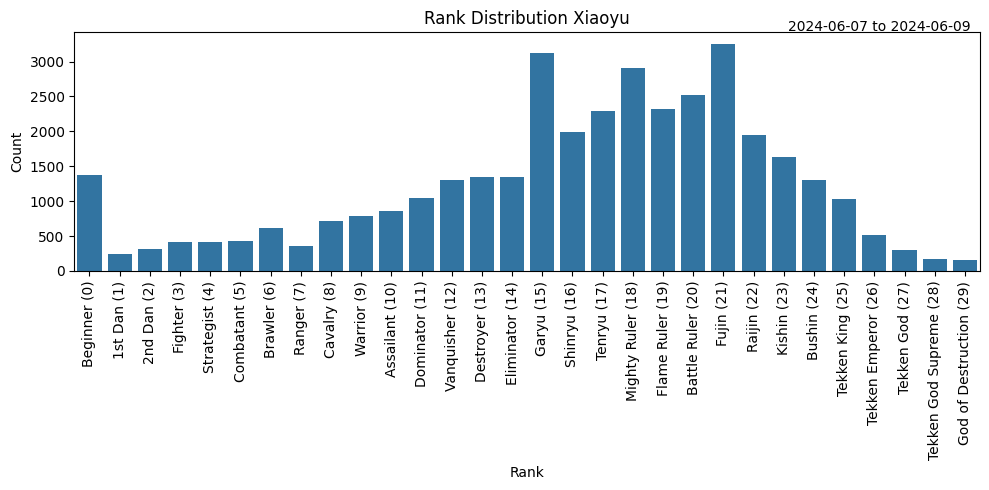

chr_0006: Jin


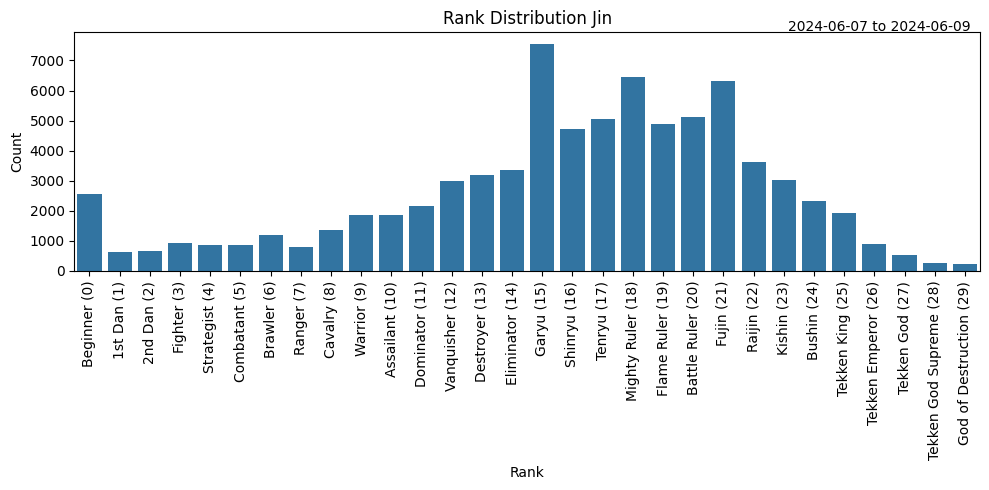

chr_0007: Bryan


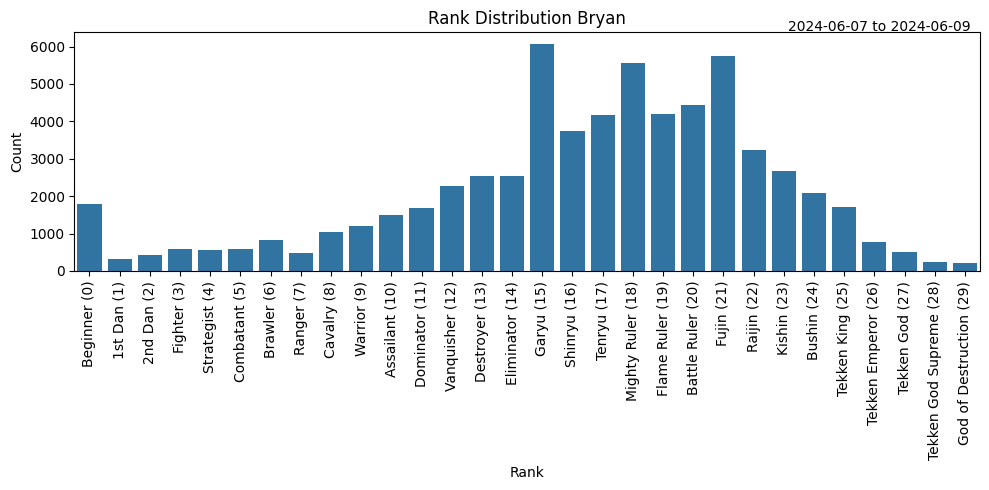

chr_0008: Kazuya


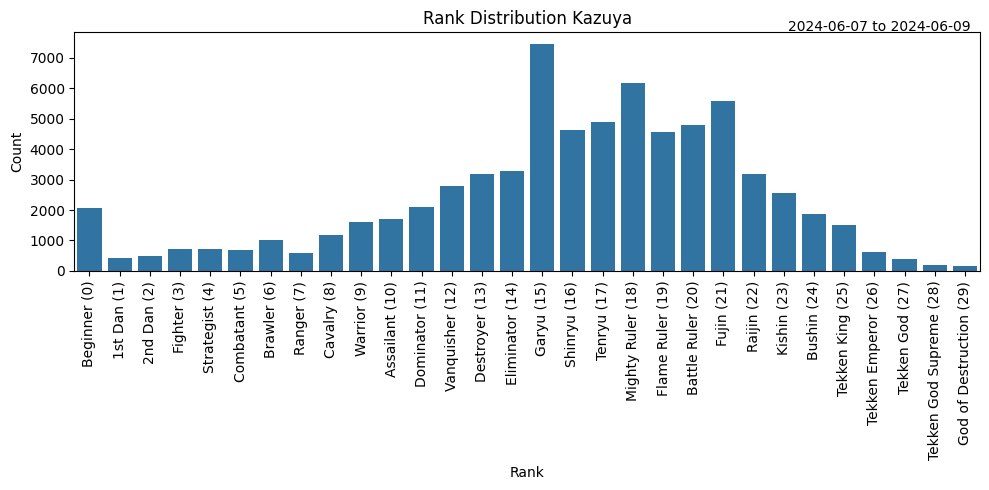

chr_0009: Steve


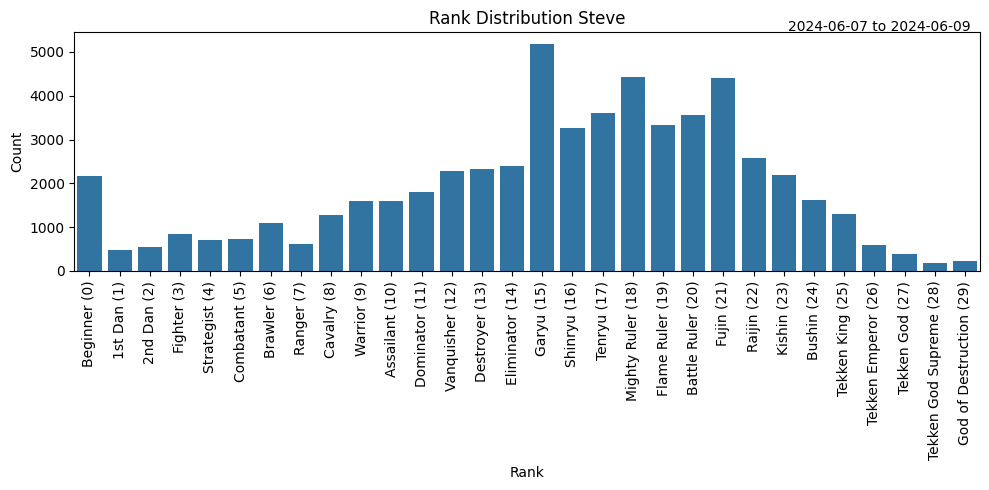

chr_0010: Jack-8


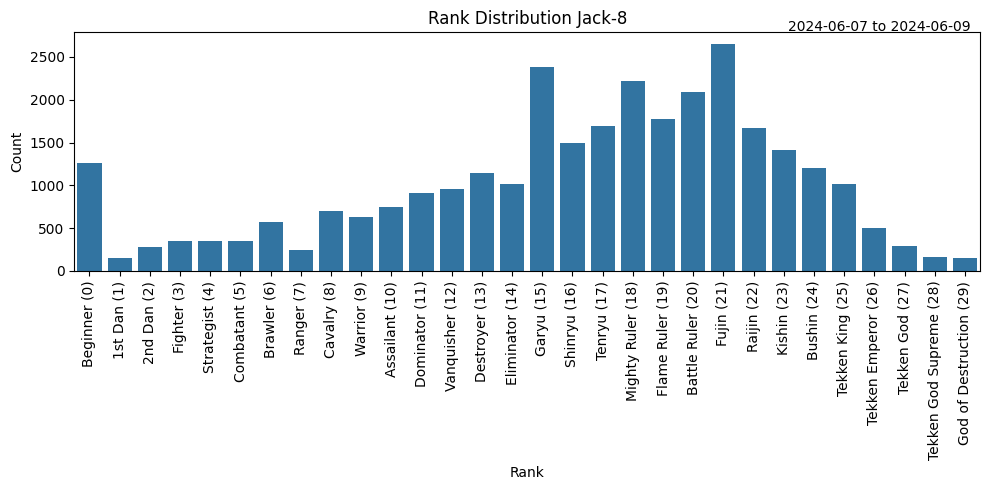

chr_0011: Asuka


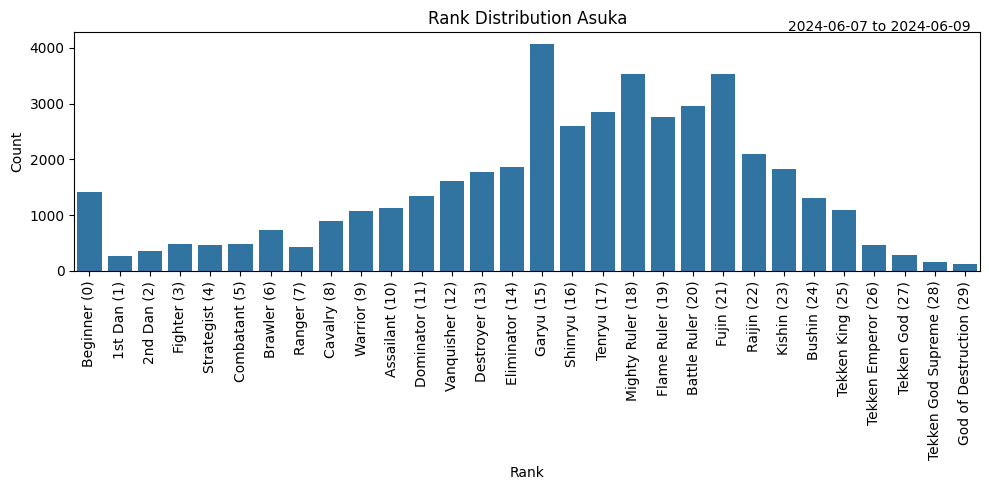

chr_0012: Devil Jin


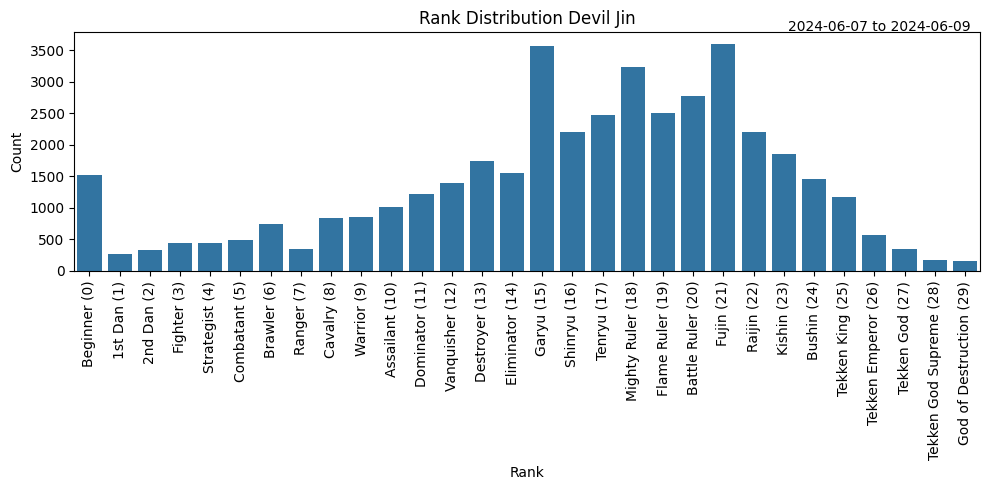

chr_0013: Feng


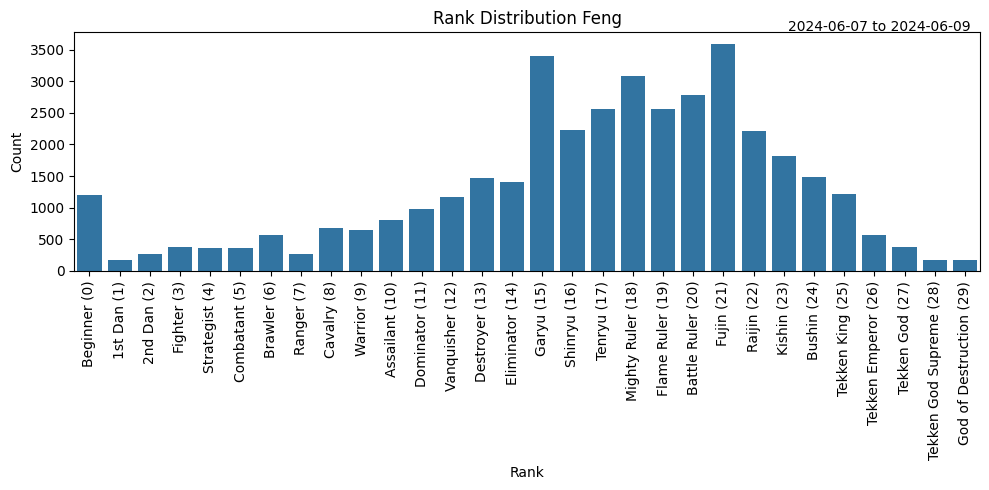

chr_0014: Lili


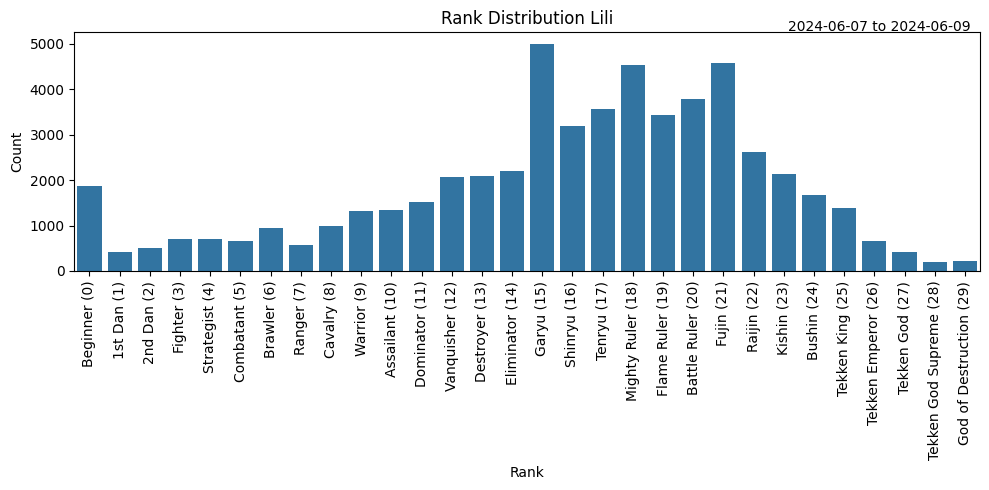

chr_0015: Dragunov


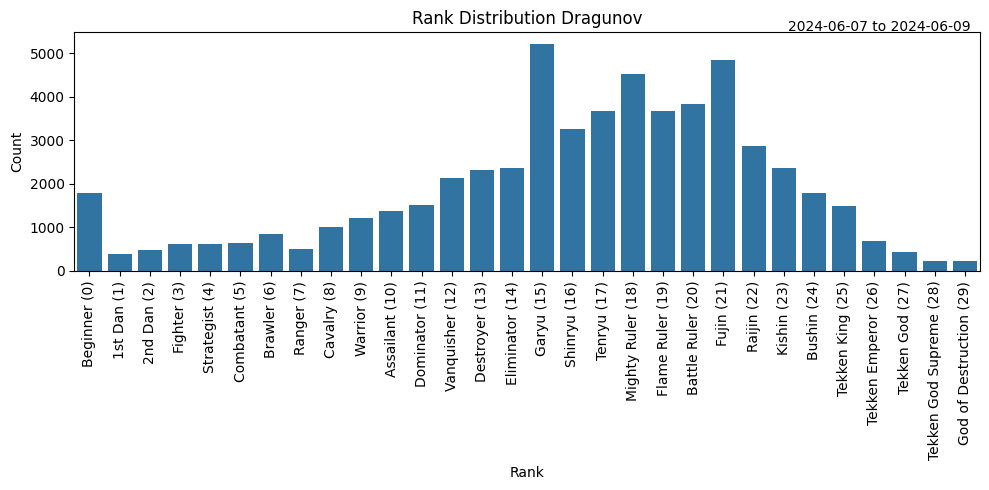

chr_0016: Leo


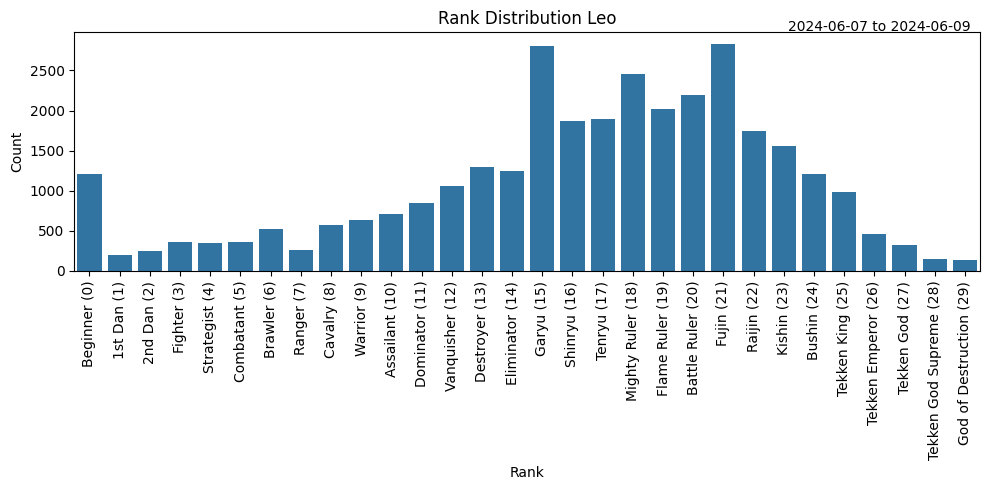

chr_0017: Lars


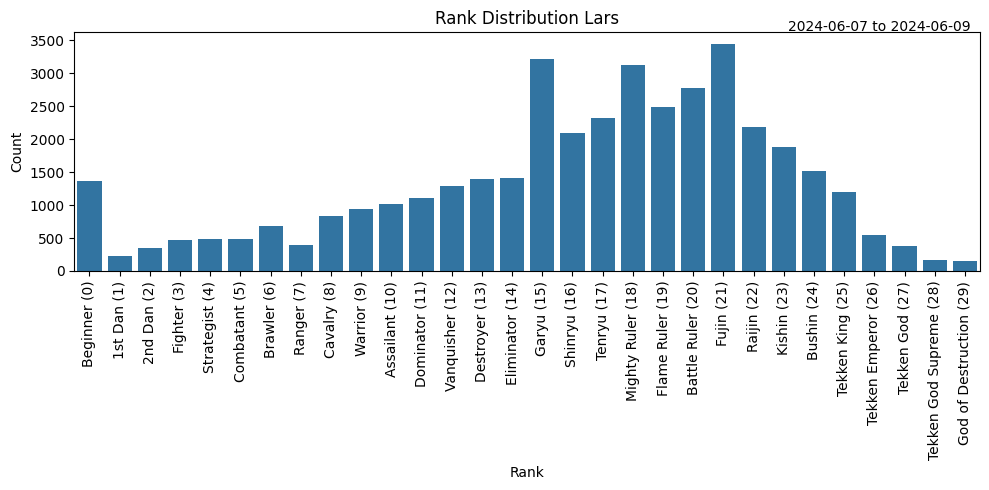

chr_0018: Alisa


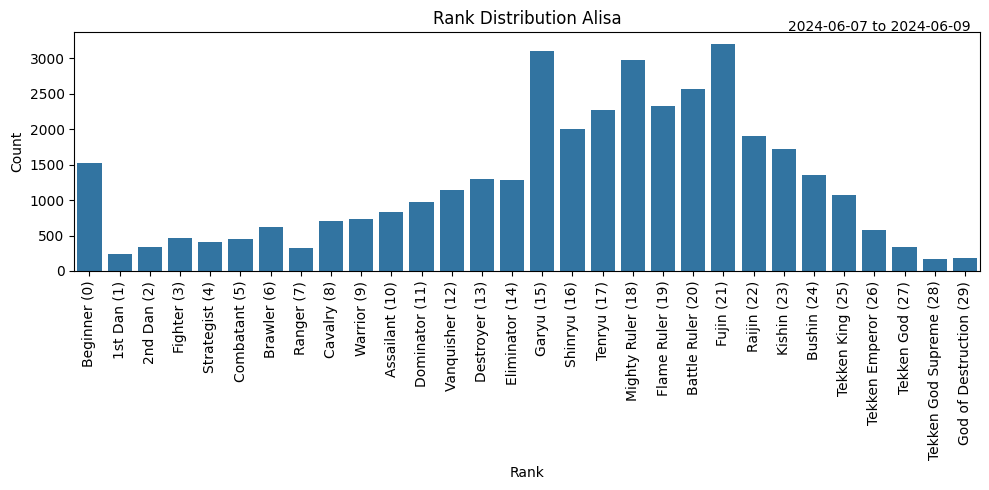

chr_0019: Claudio


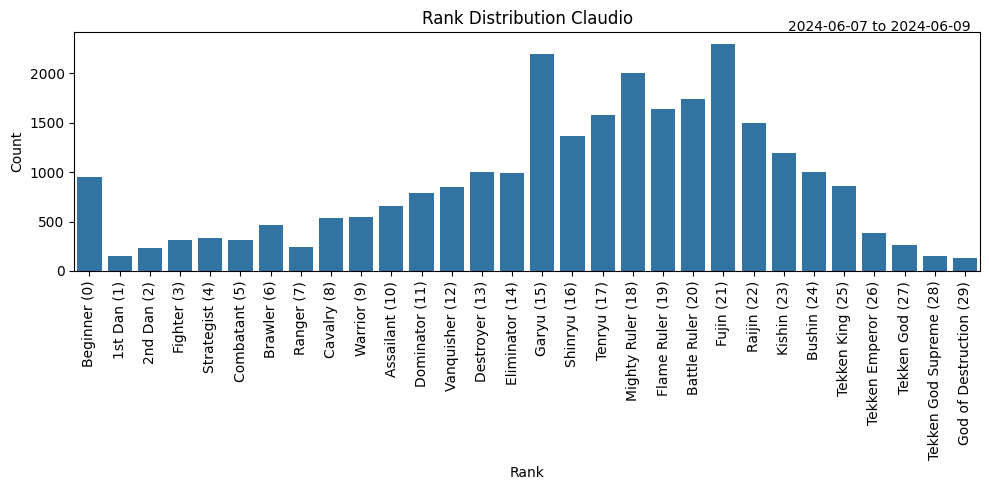

chr_0020: Shaheen


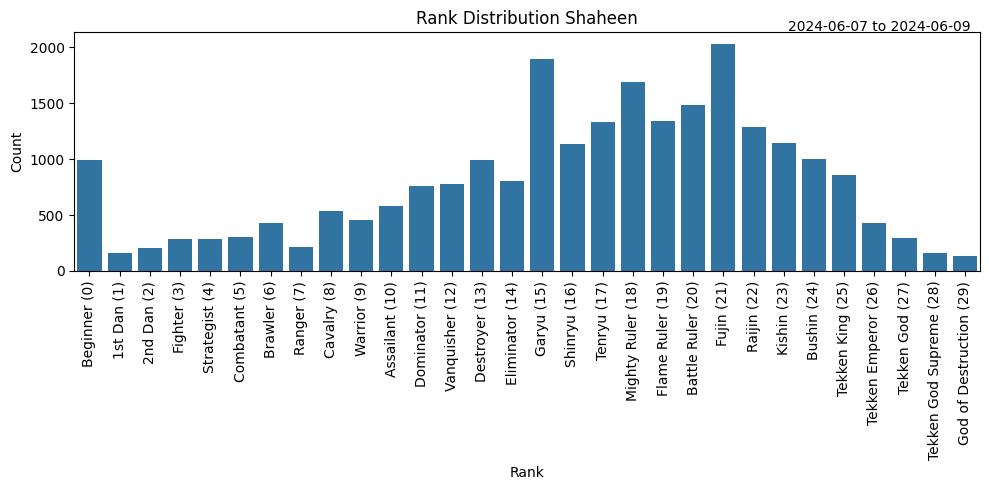

chr_0021: Nina


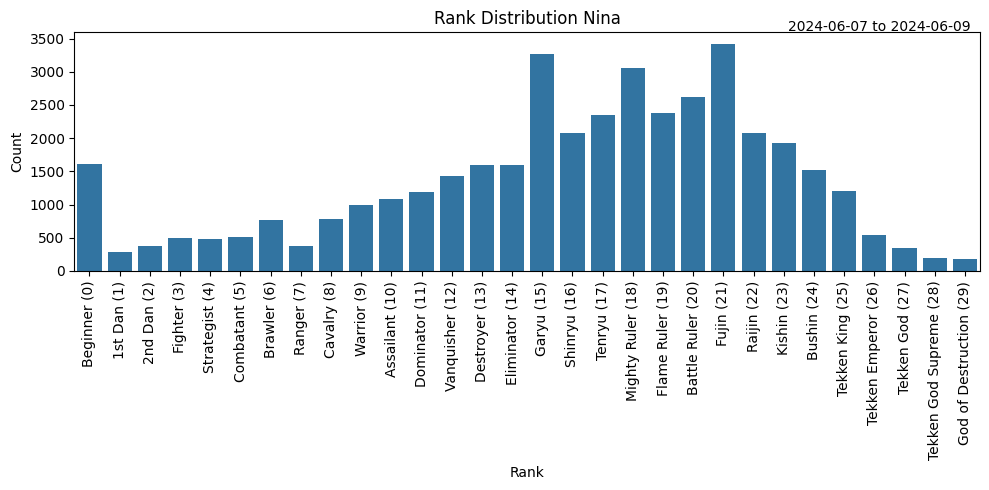

chr_0022: Lee


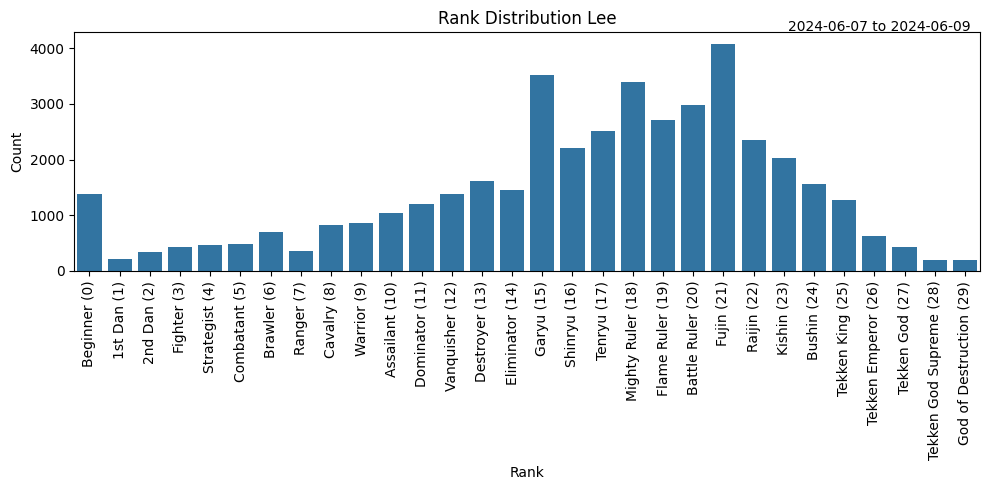

chr_0023: Kuma


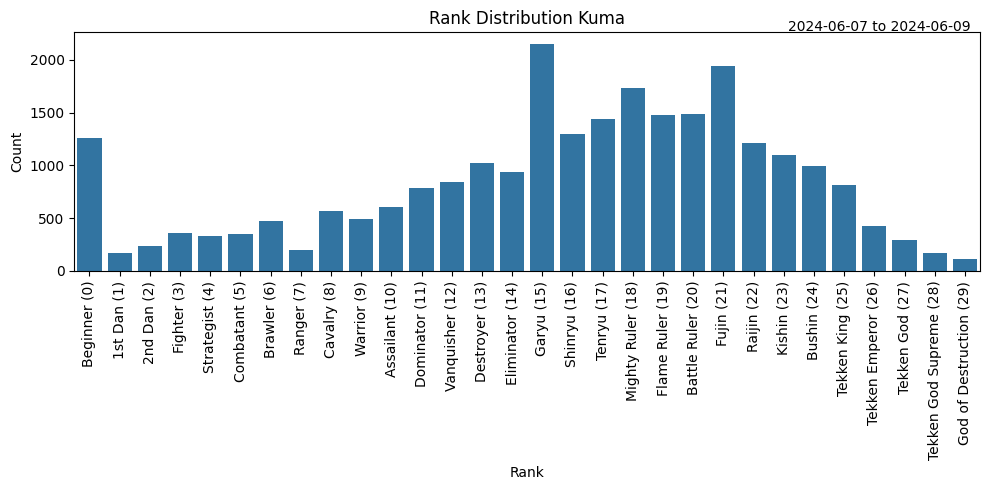

chr_0024: Panda


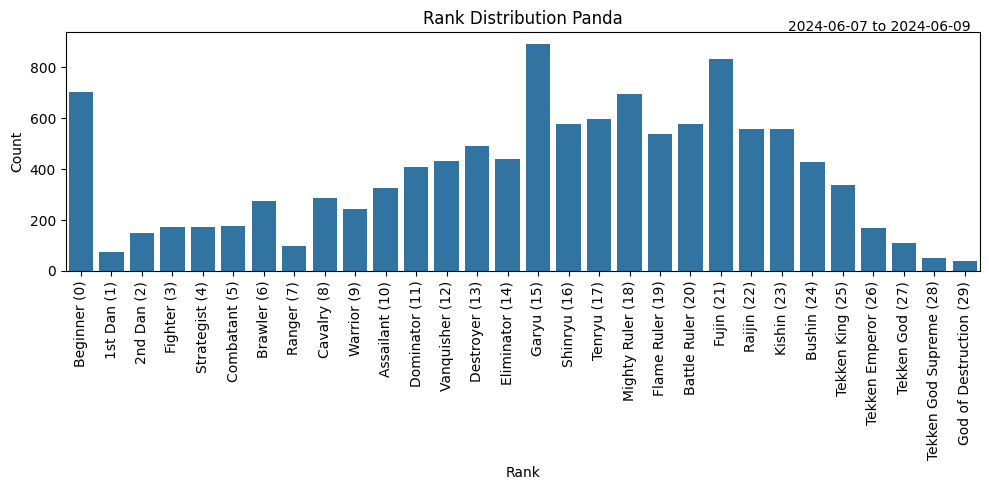

chr_0028: Zafina


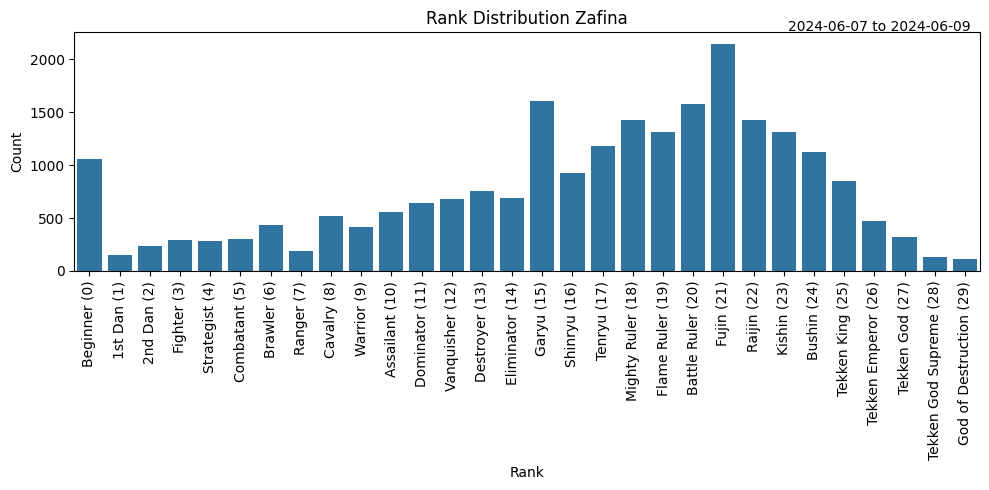

chr_0029: Leroy


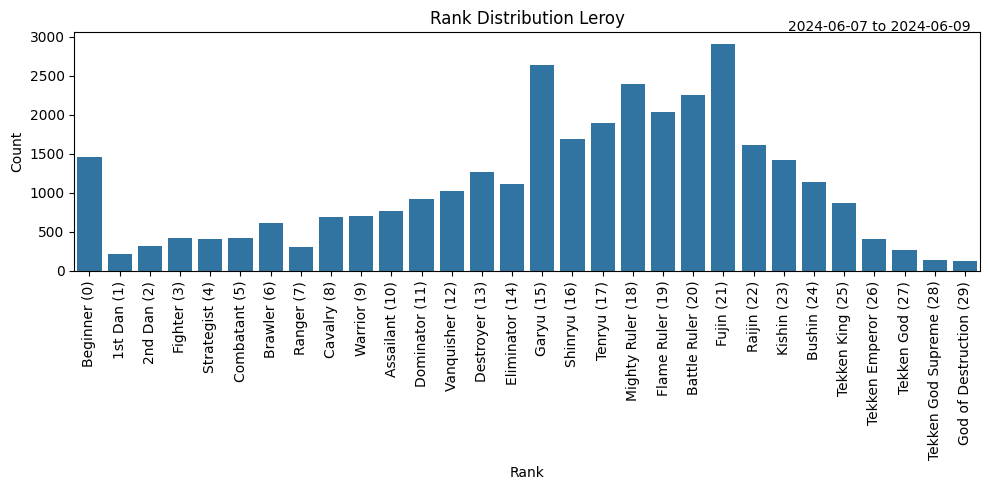

chr_0032: Jun


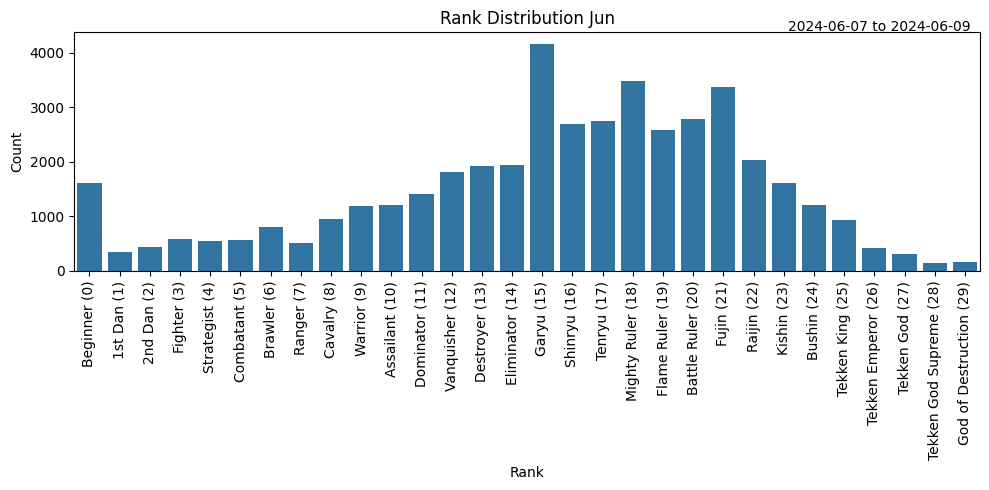

chr_0033: Reina


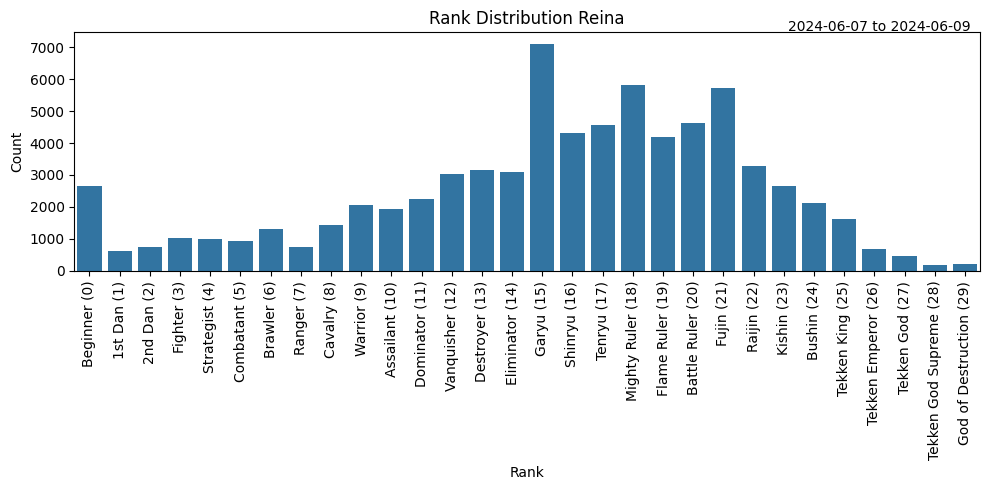

chr_0034: Azucena


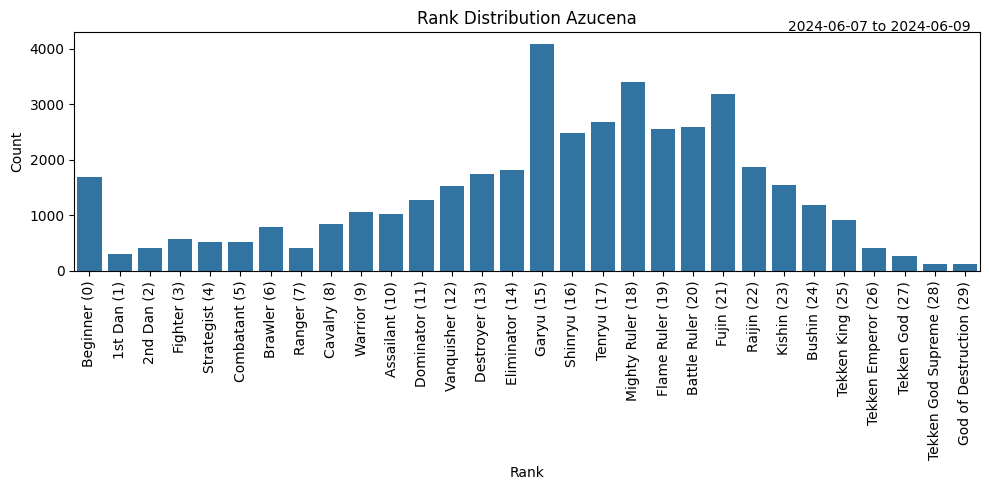

chr_0035: Victor


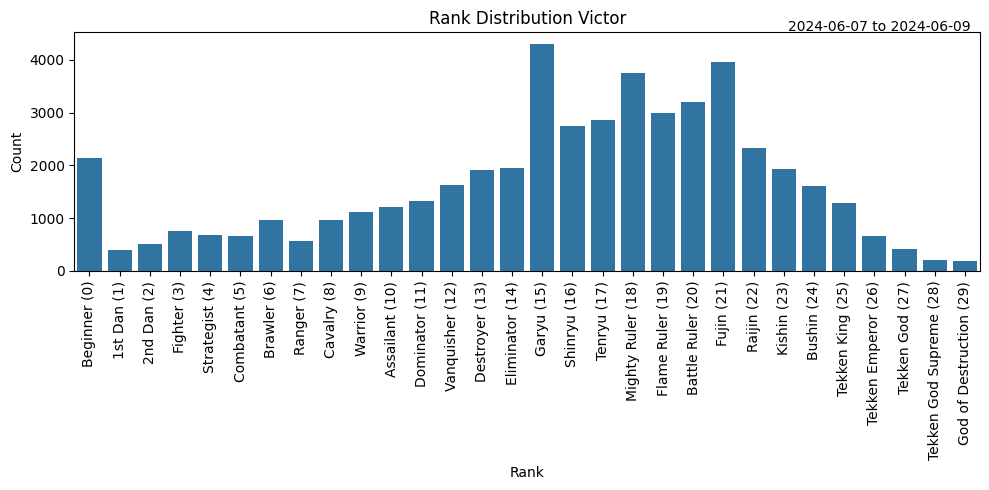

chr_0036: Raven


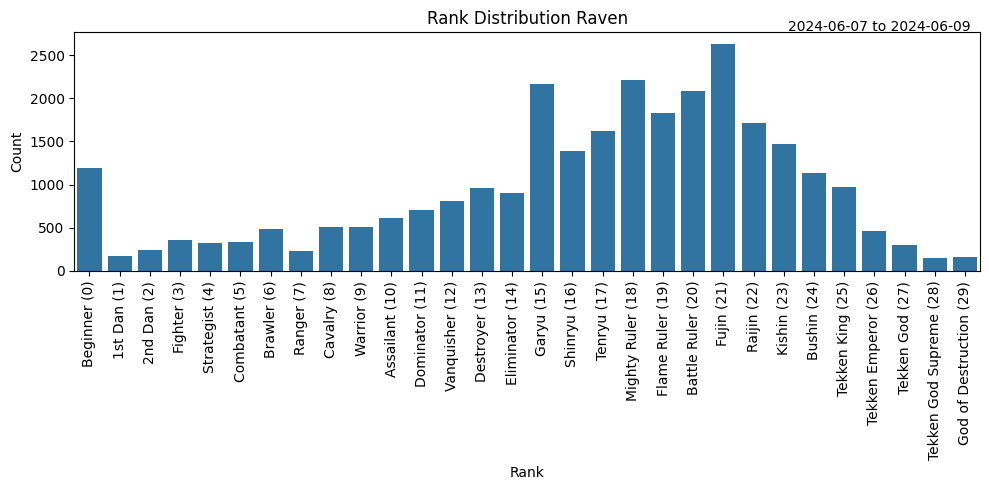

chr_0038: Eddy


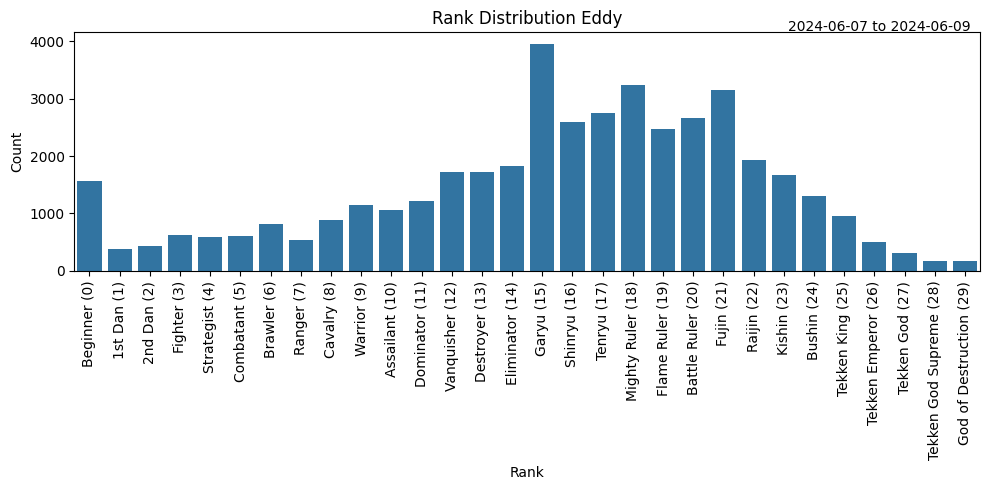

In [16]:
# generate plots for each character
for char in char_dict.keys():
    print(f'{char}: {char_dict[char]}')

    char_games = master_df[(master_df['1pCharaId'] == char) | (master_df['2pCharaId'] == char)]
     
    # plot distribution of rank for games with this character
    char_rank_counts = get_rank_distribution(get_unique_players(char_games))
    plot_rank_distribution(char_rank_counts, data_date_range, title=f'Rank Distribution {char_dict[char]}')

In [17]:
# lets count how many players there are on each platform using unique_players
platform_counts = Counter([data['platform'] for user_id, data in unique_players.items()])
platform_counts = dict(platform_counts)
platform_counts = {k: v for k, v in sorted(platform_counts.items(), key=lambda item: item[1], reverse=True)}

# replace the platform names with the actual names from the platform dictionary
platform_counts = {platform_dict[k]: v for k, v in platform_counts.items()}

# lets normalize the counts
total = sum(platform_counts.values())
platform_counts = {k: v/total for k, v in platform_counts.items()}

# combine ps? and xbox? into a single category
platform_counts['console'] = platform_counts[platform_dict[8]] + platform_counts[platform_dict[9]]


platform_counts

{'pc': 0.5020985729703802,
 'console/PS?': 0.4145707234869762,
 'console/XBOX?': 0.08333070354264363,
 'console': 0.4979014270296198}

In [18]:
# let's save the unique players dictionary to a csv file

with open('unique_players.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['user_id', 'rank', 'char', 'platform', 'tekken_power', 'characters'])
    for user_id, data in unique_players.items():
        writer.writerow([user_id, data['rank'], data['char'], platform_dict[data['platform']], data['tekken_power'], data['characters']])

# now let's do the same for the master dataframe
    
# let's first remove duplicate replays based on the battleId   

# let's save the master dataframe to a csv file
master_df.to_csv('replays.csv', index=False)

In [19]:
import yaml

character_counts = get_most_popular_characters(unique_players)
win_rates, win_rates_intervals = calculate_win_rates_with_confidence_interval(master_df)
# Calculate win rates for each bracket
beginner_win_rates, beginner_win_rates_intervals = calculate_win_rates_with_confidence_interval(beginner_games)
intermediate_win_rates, intermediate_win_rates_intervals = calculate_win_rates_with_confidence_interval(intermediate_games)
advanced_win_rates, advanced_win_rates_intervals = calculate_win_rates_with_confidence_interval(advanced_games)

Number of mirror matches: 82037
Number of matches with draws: 0
Number of mirror matches: 11800
Number of matches with draws: 0
Number of mirror matches: 52013
Number of matches with draws: 0
Number of mirror matches: 3063
Number of matches with draws: 0


In [20]:
# Compile the visual data into a single YAML report
report_data = {
    'Number of unique players': len(unique_players),
    'Number of beginner players': len(beginner_players),
    'Number of intermediate players': len(intemediate_players),
    'Number of advanced players': len(advanced_players),
    'Number of unique games': len(master_df),
    'Number of beginner games': len(beginner_games),
    'Number of intermediate games': len(intermediate_games),
    'Number of advanced games': len(advanced_games),
    'Average win rate': average_win_rate,
    'Rank distribution': rank_counts,
    'Platform distribution': platform_counts,
    'Character counts': character_counts,
    'Beginner win rates': beginner_win_rates,
    'Intermediate win rates': intermediate_win_rates,
    'Advanced win rates': advanced_win_rates,
}

with open('report.yaml', 'w') as f:
    yaml.safe_dump(report_data, f, sort_keys=False)


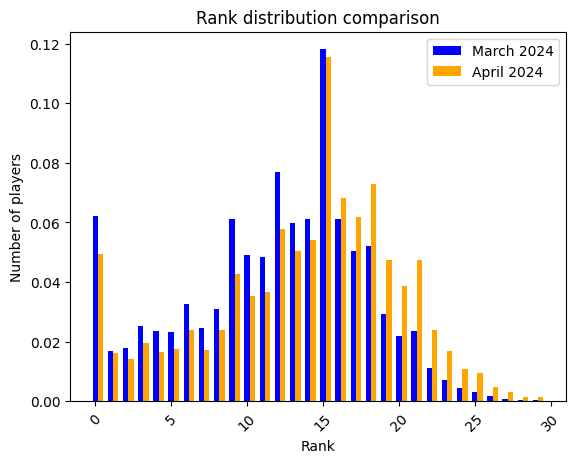

In [21]:
new_rank_distribution = {
    16: 11330,
    14: 8988,
    8: 3970,
    18: 12113,
    25: 1561,
    13: 8339,
    5: 2897,
    4: 2768,
    17: 10254,
    21: 7883,
    20: 6444,
    19: 7856,
    23: 2785,
    15: 19152,
    10: 5869,
    22: 3987,
    12: 9595,
    11: 6111,
    9: 7078,
    7: 2851,
    29: 252,
    27: 500,
    26: 799,
    1: 2669,
    3: 3233,
    24: 1813,
    2: 2348,
    0: 8208,
    6: 3974,
    28: 251
}

old_rank_distribution = {
    10 : 10906,
    0: 13794,
    14: 13602,
    13: 13279,
    12: 17054,
    9: 13600,
    6: 7239,
    19: 6528,
    17: 11223,
    3: 5641,
    15: 26187,
    16: 13571,
    18: 11564,
    20: 4851,
    11: 10755,
    8: 6847,
    7: 5484,
    4: 5217,
    5: 5123,
    2: 3976,
    21: 5212,
    22: 2450,
    27: 188,
    1: 3779,
    26: 369,
    23: 1554,
    25: 676,
    24: 984,
    28: 97,
    29: 79
}

# Sort the keys
new_rank_distribution = {k: new_rank_distribution[k] for k in sorted(new_rank_distribution)}
old_rank_distribution = {k: old_rank_distribution[k] for k in sorted(old_rank_distribution)}

# replace the rank numbers with the actual rank names
new_rank_distribution = {dan_names_dict[k]: v for k, v in new_rank_distribution.items()}
old_rank_distribution = {dan_names_dict[k]: v for k, v in old_rank_distribution.items()}

# normalize the counts
total = sum(new_rank_distribution.values())
new_rank_distribution = {k: v/total for k, v in new_rank_distribution.items()}

total = sum(old_rank_distribution.values())
old_rank_distribution = {k: v/total for k, v in old_rank_distribution.items()}

# plot old and new rank distributions on the same axes to compare them
# we have to use different colors for each distribution
fig, ax = plt.subplots()
plt.xticks(rotation=45)
bar_positions = np.arange(len(old_rank_distribution))
bar_width = 0.35

ax.bar(bar_positions, old_rank_distribution.values(), width=bar_width, color='blue', label='March 2024')
ax.bar(bar_positions + bar_width, new_rank_distribution.values(), width=bar_width, color='orange', label='April 2024')

ax.set_xlabel('Rank')
ax.set_ylabel('Number of players')
ax.set_title('Rank distribution comparison')
ax.legend()


plt.show()




In [22]:
# load data from the data folder into a different dataframe
data_directory = './data/'
data_df = read_data_into_dataframe(data_directory)
data_df = data_df[data_df['battleType'] == 2]
data_df.info()

Read 0 games from 0 files
0 files were unable to be read


KeyError: 'battleType'

In [ ]:
# convert from unix timestamp to datetime
data_df['battleAt'] = pd.to_datetime(data_df['battleAt'], unit='s')

# plot distribution of time of day game was played
data_df['battleAt'].dt.hour.hist(bins=24)

# get the date range of the data as a human readable string
data_date_range = f"{data_df['battleAt'].dt.date.min()} to {data_df['battleAt'].dt.date.max()}"
print(data_date_range)

In [ ]:
# iterate over the master dataframe and calculate the difference in tekken power for each game
# then calculate the mean difference
ranked_master_df = master_df[master_df['battleType'] == 2]

def calculate_summary_ranked_stats(df):
    import seaborn as sns
    tekken_power_diffs = tekken_power_diffs = (df['1pTekkenPower'] - df['2pTekkenPower']).abs()
    mean_diff = tekken_power_diffs.mean()
    print(f'The mean difference in tekken power is {mean_diff}')

    # also calculate the standard deviation of the difference in tekken power
    std_diff = tekken_power_diffs.std()
    print(f'The standard deviation of the difference in tekken power is {std_diff}')

    # max difference in tekken power
    max_diff = tekken_power_diffs.max()
    print(f'The max difference in tekken power is {max_diff}')

    # plot dstribution of the difference in tekken power using seaborn
    # make sure to give the plot a title, x axis label and useful ticks
    sns.histplot(tekken_power_diffs, kde=True, bins=100)
    plt.xlabel('Difference in tekken power')
    plt.title('Distribution of the difference in tekken power')
    plt.show()

    # find the mean difference in tekken rank 
    # iterate over the master dataframe and calculate the difference in tekken rank for each game
    # making sure to use the absolute value of the difference
    # then calculate the mean difference
    tekken_rank_diffs = (df['1pRank'] - df['2pRank']).abs()
    mean_diff = tekken_rank_diffs.mean()
    print(f'The mean difference in tekken rank is {mean_diff}')

    # plot dstribution of the difference in tekken rank using seaborn
    # make sure to give the x axis a label and useful ticks
    sns.histplot(tekken_rank_diffs, bins=30)
    plt.xlabel('Difference in tekken rank')
    plt.show()    

    
    # also calculate the standard deviation of the difference in tekken rank
    std_diff = tekken_rank_diffs.std()
    print(f'The standard deviation of the difference in tekken rank is {std_diff}')


    # let's also figure out the mean number of rounds in a game
    mean_rounds = df['totalRoundNum'].mean()
    print(f'The mean number of rounds in a game is {mean_rounds}')

    #and also the standard deviation
    std_rounds = df['totalRoundNum'].std()
    print(f'The standard deviation of the number of rounds in a game is {std_rounds}')


    # let's also figure out how much predicitve power the prowess rating has
    # we can do this by calculating the correlation between the prowess rating and the outcome of the game
    # we can use the spearman correlation
    correlation = df['2pTekkenPower'] - df['1pTekkenPower']
    correlation = correlation.corr(df['winResult'], method='spearman')
    print(f'The correlation between the prowess rating and the outcome of the game is {correlation}')


    # let's also figure out how much predicitve power the rank has
    # we can do this by calculating the correlation between the rank and the outcome of the game
    # we can use the spearman correlation
    correlation = df['2pRank'] - df['1pRank']
    correlation = correlation.corr(df['winResult'], method='spearman')
    print(f'The correlation between the rank and the outcome of the game is {correlation}')


In [ ]:
ranked_master_df.info()

In [ ]:
calculate_summary_ranked_stats(ranked_master_df)

In [ ]:
calculate_summary_ranked_stats(data_df)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rank_distribution(rank_counts, date_range, title):
    labels = [f'{dan_names_dict[k]} ({k})' for k in dan_names_dict.keys()][:-1]
    print(labels)

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(10, 5))
    fig, ax = plt.subplots()
    ax.bar(x - width/2, rank_counts[0], width, label=date_range[0])
    ax.bar(x + width/2, rank_counts[1], width, label=date_range[1])


    ax.set_xlabel('Rank')
    ax.set_ylabel('Number of players')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xticks(rotation=90)

    ax.legend()

    plt.show()


In [ ]:
#TODO: figure out why destroyuers are not being displayed in the rank distribution plot
#TODO: do this with the may vs april data
plot_rank_distribution([rank_counts, rank_counts], ['March 2024', 'April 2024'], 'Rank distribution comparison')

In [ ]:

# plot the distribution of tekkken power for all unique players using a kde plot
tekken_power_values = [data['tekken_power'] for user_id, data in unique_players.items()]
plt.xlabel('Distribution of Tekken Power')
plt.title('Tekken Power')
sns.histplot(tekken_power_values, kde=False, bins=200)

In [ ]:
# let's plot the average tekken power for each rank
average_tekken_power = {}
for rank in dan_names_dict.keys():
    average_tekken_power[rank] = []
    for user_id, data in unique_players.items():
        if data['rank'] == rank:
            average_tekken_power[rank].append(data['tekken_power'])
    average_tekken_power[rank] = np.mean(average_tekken_power[rank])

average_tekken_power = {k: v for k, v in sorted(average_tekken_power.items())}
plt.bar(average_tekken_power.keys(), average_tekken_power.values())
plt.xlabel('Rank')
plt.ylabel('Average Tekken Power')
plt.title('Average Tekken Power for each Rank')
plt.show()

In [ ]:
#TODO: longest common substring maybe?

def levenshteinDistanceDP(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(token1)][len(token2)]

    
# now we can iterate over the master dataframe and calculate the similarity between the names of each pair of players
# then we can find the pair with the smallest distance
min_similarity = np.inf
min_similarity_pair = None
for index, row in ranked_master_df.iterrows():
    similarity = levenshteinDistanceDP(row['1pPlayerName'], row['2pPlayerName'])
    if similarity <= min_similarity:
        min_similarity = similarity
        min_similarity_pair = (row['1pPlayerName'], row['2pPlayerName'])
        print(row[['1pPlayerName', '2pPlayerName', '1pCharaId', '2pCharaId', 'winResult', '1pRank', '2pRank']])
        print(f'Similarity: {similarity}')
        print('\n\n')

print(f'The pair of players with the most similar names are {min_similarity_pair} with a similarity score of {min_similarity}')

In [ ]:
# what is the stage with the highest win rate for chr_0033
# we can do this by filtering the master dataframe to only include games where chr_0033 is present
# then we can calculate the win rate for each stage
# then we can find the stage with the highest win rate

def get_stage_winrates_for_char(char = 'chr_0014'):
    chr_0033_games = ranked_master_df[(ranked_master_df['1pCharaId'] == char) | (ranked_master_df['2pCharaId'] == char)]
    stage_win_rates = {}
    for stage in stage_dict.keys():
        stage_games = chr_0033_games[chr_0033_games['stageId'] == stage]
        win_count = stage_games[(stage_games['winResult'] == 1) & (stage_games['1pCharaId'] == char)].shape[0]
        win_count += stage_games[(stage_games['winResult'] == 2) & (stage_games['2pCharaId'] == char)].shape[0]
        total_games = stage_games.shape[0]
        if total_games == 0:
            stage_win_rates[stage] = 0
        else:
            stage_win_rate = win_count / total_games

        stage_win_rates[stage_dict[stage]] = stage_win_rate

    stage_win_rates = {k: v for k, v in sorted(stage_win_rates.items(), key=lambda item: item[1], reverse=True)}
    return stage_win_rates

stage_win_rates = get_stage_winrates_for_char()
print(stage_win_rates)
